## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 14:11:51--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  5.79MB/s    in 1.0s    

2025-03-02 14:11:53 (5.79 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [ ]:
import pandas as pd
import numpy as np
from typing import Union

In [318]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [319]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [320]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [321]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [322]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [323]:
len(user_le.classes_), len(item_le.classes_)

(5365, 3010)

In [324]:
df_train['user_id'].nunique(), df_train['user_id'].max()


(5365, 5364)

In [325]:
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [326]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    #your code here
    users = len(user_le.classes_)
    items = len(item_le.classes_)
    result = np.zeros((users, items))
    for _, row in df.iterrows():
        result[int(row['user_id']), int(row['item_id'])] = row['rating']
    return result #shape ~ [n_users, n_items]

In [327]:
interactions = df_to_matrix(df_train)

In [329]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    #your code here
    users = len(user_le.classes_)
    items = len(item_le.classes_)
    result = coo_array((df['rating'].astype(np.float64), (df['user_id'], df['item_id'])), shape=(users, items))

    return result # coo_array

In [330]:
coo_interactions = df_to_coo(df_train)

In [331]:
print(type(coo_interactions))
print(isinstance(coo_interactions, coo_array))
isinstance(interactions, np.ndarray)

<class 'scipy.sparse._coo.coo_array'>
True


True

In [332]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [333]:
from scipy.sparse.linalg import svds
from numpy.linalg import svd

def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)


    #your code here
    if isinstance(interractions, coo_array):
        if n_singular_values == -1:
            n_singular_values = interractions.shape[0] - 1
        U, S, V = svds(interractions, k=n_singular_values)
    else:
        U, S, V = svd(interractions, full_matrices=False)
        if n_singular_values != -1:
          S = S[:n_singular_values]
          U = U[:, :n_singular_values]
          V = V[:n_singular_values]

    return U, np.diag(S), V

In [334]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [335]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [336]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    #your code here
    U, S, V = make_svd(interractions, n_singular_values)
    recommendations = U @ S @ V
    if isinstance(interractions, coo_array):
        recommendations[interractions.row, interractions.col] = -np.inf
    else:
        recommendations[interractions != 0] = -np.inf
    recommendations = np.argsort(recommendations, axis=1)[:, -top_k:]
    # и выводим в порядке увеличения релевантности
    return recommendations[:, ::-1]



In [337]:
test_matrix = df_to_matrix(df_test)
test_matrix_sparse = df_to_coo(df_test)


In [338]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [ ]:
# возьмем код с семинара для метрик

In [339]:
def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items, predicted):

    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt

def evaluate_recommender(test_matrix, recommendations, topn=10):
    metric_values = []

    for user in range(recommendations.shape[0]):
      gt_items = np.where(test_matrix[user] != 0)[0]
      if len(gt_items) == 0:
        continue
      metric_values.append((ndcg_metric(gt_items, recommendations[user]), recall_metric(gt_items, recommendations[user])))

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}


In [340]:
test_matrix = df_to_matrix(df_test)

In [341]:
rec1 = make_svd_recommendations(coo_interactions, 200, 100)
evaluate_recommender(test_matrix, rec1, 100)

{'ndcg': 0.51835306935443, 'recall': 0.18299551293344127}

In [342]:
import time
import matplotlib.pyplot as plt

def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    #your code here
    ndcg = []
    times = []
    n_singular_values = [1, 10, 50, 200, 1000]

    for n_singular_value in n_singular_values:
        start = time.time()
        recs = make_svd_recommendations(interractions, n_singular_value, top_k)
        metrics = evaluate_recommender(test_matrix, recs, top_k)
        times.append(time.time() - start)
        ndcg.append(metrics['ndcg'])

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.plot(n_singular_values, ndcg)
    plt.title('NDCG vs n_singular_values')
    plt.xlabel('n_singular_values')
    plt.ylabel('NDCG')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(n_singular_values, times)
    plt.title('Time vs n_singular_values')
    plt.xlabel('n_singular_values')
    plt.ylabel('Time')
    plt.grid()

    plt.show()
    return ndcg


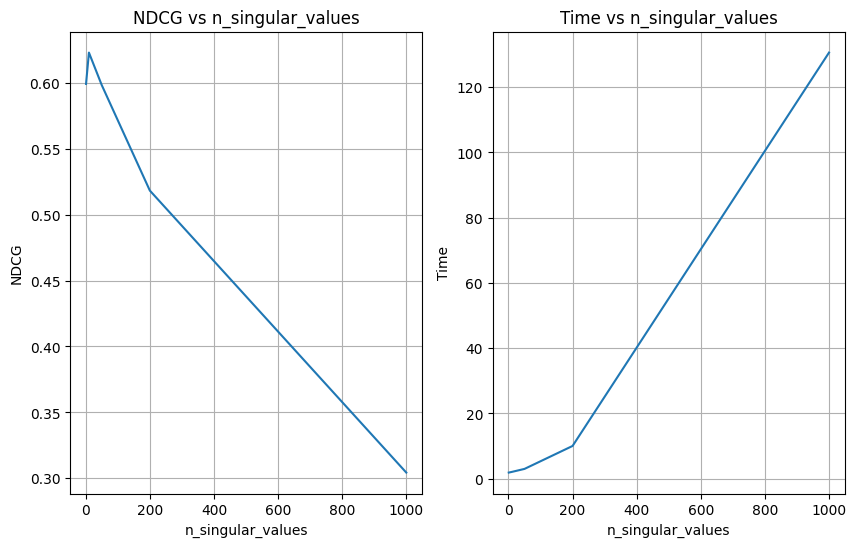

In [ ]:
ndcg = plot_graphs(coo_interactions, 100)

Как мы видим, при большом количестве сингулярных чисел, произошло переобучение, что в принципе объяснимо, так как мы максимально хорошо приближаем исходную матрицу рейтинго и модель имеет низкую обобщающую способность. Лучшее ndcg при количестве сингулярных чисел = 10

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [ ]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 59.8 MB/s eta 0:00:00


In [ ]:
from implicit.cpu.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix

def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
     als = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
     user_items = interractions.tocsr()
     als.fit(user_items)
     user_id = np.arange(user_items.shape[0])
     recommendations = als.recommend(user_id, user_items=user_items, N=top_k, filter_already_liked_items=True)
     return recommendations[0] #shape ~ [n_users, top_k]

In [ ]:
def best_params(interractions: Union[np.ndarray, coo_array], test_matrix, top_k: int = 100):
    n_factors = np.array([5, 8, 9, 10, 13, 15])
    alpha = np.array([1., 4., 10.])
    regularization = np.array([0.001, 0.1])
    best_ndcg = 0
    best_params = None
    for n_factor in n_factors:
        for alph in alpha:
            for reg in regularization:
                recs = make_als_recommendations(coo_matrix(interractions), top_k, n_factor, alph, reg)
                metrics = evaluate_recommender(test_matrix, recs, 100)
                if metrics['ndcg'] > best_ndcg:
                    best_ndcg = metrics['ndcg']
                    best_params = (n_factor, alph, reg)
    return best_params

best_params(interactions, test_matrix)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

(8, 1.0, 0.001)

In [ ]:
predictions = make_als_recommendations(coo_matrix(interactions), n_factors=8, alpha=1.0, regularization=0.001)
metrics = evaluate_recommender(test_matrix, predictions, 100)
print(metrics)


  0%|          | 0/15 [00:00<?, ?it/s]

{'ndcg': 0.6303792529765491, 'recall': 0.2639025867623709}


In [ ]:
rec1 = make_svd_recommendations(coo_interactions, 10, 100)
evaluate_recommender(test_matrix, rec1, 100)


{'ndcg': 0.623132974127492, 'recall': 0.2583784105921062}

**Выводы:**
Провел несколько экспериментов и обнаружил, что слишком большое число факторов > 30 лишь понижает метрики, поэтому выбрал для числа факторов значения -- 5, 8, 9, 10, 13, 15

Выбрали лучшие гиперпараметры -- n_factors = 8
alpha = 1, reg = 0.001

Как мы видим выше, метрики NDCG и recall у алгоритма ALS выше, чем у лучших гиперпараметров для SVD разложения.



In [ ]:
recs = make_als_recommendations(coo_matrix(interactions))
assert recs.shape == (interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [227]:
als = AlternatingLeastSquares(factors=8, regularization=0.001, alpha=1.0)
user_items = coo_matrix(interactions).tocsr()
als.fit(user_items)
user_id = np.arange(user_items.shape[0])
recommendations = als.recommend(user_id, user_items=user_items, N=100, filter_already_liked_items=True)



  0%|          | 0/15 [00:00<?, ?it/s]

In [294]:
movies = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', encoding='latin-1')
movies.columns = ['movie_id', 'title', 'genre']
movies.iloc[-100:,]

,movie_id,title,genre
3782,3853,"Tic Code, The (1998)",Drama
3783,3854,Aimée & Jaguar (1999),Drama|Romance
3784,3855,"Affair of Love, An (Une Liaison Pornographique...",Drama|Romance
3785,3856,Autumn Heart (1999),Drama
3786,3857,Bless the Child (2000),Thriller
...,...,...,...
3877,3948,Meet the Parents (2000),Comedy
3878,3949,Requiem for a Dream (2000),Drama
3879,3950,Tigerland (2000),Drama
3880,3951,Two Family House (2000),Drama



**Посмотрим фильм Star Wars: Episode VI - Return of the Jedi (1983) -- id 889**

In [315]:
movies[movies['movie_id'] ==item_le.inverse_transform([2045])[0]].title.values[0]

'American Pie (1999)'

In [287]:
def print_recommendations(als, id_movie, id_user, user_items, N=5):
  score, top_contributions, _ = als.explain(id_user, itemid=id_movie, user_items=user_items, N=5)
  for i in range(len(top_contributions)):
    print(top_contributions[i][0], movies[movies['movie_id'] ==item_le.inverse_transform([top_contributions[i][0]])[0]].title.values[0])




In [301]:
print_recommendations(als, 889, 1000, user_items, N=5)


211 Star Wars: Episode IV - A New Hope (1977)
875 Star Wars: Episode V - The Empire Strikes Back (1980)
877 Raiders of the Lost Ark (1981)
1940 Matrix, The (1999)
2168 American Beauty (1999)


Заметим, что так как рекомендует фильм Звездные войны, то список фильмов, которые на это решение влияние состоит как раз таки из близких по типу фильмов, у нас 2 фильма вообще части рекомендованного.  

**Посмотрим  на Silence of the Lambs id = 499**

Здесь уже хуже зависимости, хотя крестного отца модель тоже учитывает, остальные фильмы какие-то боевики и не особо связаны с ужастиком.

In [304]:
print_recommendations(als, 499, 1000, user_items, N=5)


2168 American Beauty (1999)
1497 Saving Private Ryan (1998)
94 Braveheart (1995)
2278 Being John Malkovich (1999)
638 Godfather, The (1972)


**American Pie (1999)**
Тут чуть лучше, чем в предыдущем примере, в рекомендацию вносят вклад Erin Brockovich (2000) и 2168 American Beauty (1999), что +- то же, что и фильм выше


In [317]:
print_recommendations(als, 2045, 900, user_items, N=5)


2029 Austin Powers: The Spy Who Shagged Me (1999)
2049 Blair Witch Project, The (1999)
2168 American Beauty (1999)
2579 Erin Brockovich (2000)
2854 Patriot, The (2000)


##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

1) Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1). По условию нам не нужно изменять тестовую выборку.

In [172]:
interactions_1 = interactions.copy()
interactions_1[interactions_1 > 0] = 1
test_matrix_1 = test_matrix.copy()
# test_matrix_1[test_matrix_1 > 0] = 1


recs_1 = make_als_recommendations(coo_matrix(interactions_1), n_factors=8, alpha=1.0, regularization=0.001)
metrics_1 = evaluate_recommender(test_matrix_1, recs_1, 100)

svd_1 = make_svd_recommendations(coo_array(interactions_1), n_singular_values=10, top_k=100)
metrics_svd_1 = evaluate_recommender(test_matrix_1, svd_1, 100)
print(f'NDCG ALS: {metrics_1["ndcg"]}')
print(f'NDCG SVD: {metrics_svd_1["ndcg"]}')


  0%|          | 0/15 [00:00<?, ?it/s]

NDCG ALS: 0.6162615805823151
NDCG SVD: 0.6110871157378023


2) Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0

In [173]:
interactions_2 = interactions.copy()
interactions_2[interactions_2 < 4] = 0
interactions_2[interactions_2 >= 4] = 1

test_matrix_2 = test_matrix.copy()
# test_matrix_2[test_matrix_2 < 4] = 0
# test_matrix_2[test_matrix_2 >= 4] = 1

recs_2 = make_als_recommendations(coo_matrix(interactions_2), n_factors=8, alpha=1.0, regularization=0.001)
metrics_2 = evaluate_recommender(test_matrix_2, recs_2, 100)

svd_2 = make_svd_recommendations(coo_array(interactions_2), n_singular_values=10, top_k=100)
metrics_svd_2 = evaluate_recommender(test_matrix_2, svd_2, 100)

print(f'NDCG ALS: {metrics_2["ndcg"]}')
print(f'NDCG SVD: {metrics_svd_2["ndcg"]}')

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG ALS: 0.5977170891373265
NDCG SVD: 0.5966736686870371


3) Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1

In [226]:
interactions_3 = interactions.copy()
interactions_3[(interactions_3 < 4) & (interactions_3 != 0) ] = -1
interactions_3[interactions_3 >= 4] = 1

test_matrix_3 = test_matrix.copy()
# test_matrix_3[test_matrix_3 < 4] = -1
# test_matrix_3[test_matrix_3 >= 4] = 1

recs_3 = make_als_recommendations(coo_matrix(interactions_3), n_factors=8, alpha=1.0, regularization=0.001)
metrics_3 = evaluate_recommender(test_matrix_3, recs_3, 100)

svd_3 = make_svd_recommendations(coo_array(interactions_3), n_singular_values=10, top_k=100)
metrics_svd_3 = evaluate_recommender(test_matrix_3, svd_3, 100)

print(f'NDCG ALS: {metrics_3["ndcg"]}')
print(f'NDCG SVD: {metrics_svd_3["ndcg"]}')


  0%|          | 0/15 [00:00<?, ?it/s]

NDCG ALS: 0.6284296888222497
NDCG SVD: 0.6077709151752594


4) Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы

In [207]:
train = df_train.copy()
train['datetime'] = (pd.to_datetime(train['datetime']) - pd.to_datetime(train['datetime']).min()).dt.days
train.loc[train['rating'] < 4, 'rating'] = -1
train.loc[train['rating'] >= 4, 'rating'] = 1
max_time = train.datetime.max() - 30
train.loc[train['datetime'] < max_time, 'smooth'] = train['datetime'].apply(lambda x: (x + 1) / max_time)
train.loc[train['datetime'] >= max_time, 'smooth'] = 1
train['rating'] = train['rating'] * train['smooth']
train.drop(['smooth'], axis=1, inplace=True)
train.head()

,user_id,item_id,rating,datetime
100409,0,2994,-1.0,219
100411,0,929,1.0,219
100412,0,567,1.0,219
100415,0,3005,-1.0,219
100416,0,3006,1.0,219


In [224]:
interactions_4 = df_to_matrix(train)

test_matrix_4 = test_matrix.copy()


recs_4 = make_als_recommendations(coo_matrix(interactions_4), n_factors=8, alpha=1.0, regularization=0.001)
metrics_4 = evaluate_recommender(test_matrix_4, recs_4, 100)

svd_4 = make_svd_recommendations(coo_array(interactions_4), n_singular_values=10, top_k=100)
metrics_svd_4 = evaluate_recommender(test_matrix_4, svd_4, 100)

print(f'NDCG ALS: {metrics_4["ndcg"]}')
print(f'NDCG SVD: {metrics_svd_4["ndcg"]}')


  0%|          | 0/15 [00:00<?, ?it/s]

NDCG ALS: 0.6312147380862447
NDCG SVD: 0.6079676103873671


**Выводы**:

Четвертый подход, когда мы учитываем сглаживаем релевантности, оказался лучше всего, метрика NDCG на нем выше, чем в предыдущих экспериментах, даже немного опережает случай, когда мы не меняли рейтинги вообще. Скорее всего это объяснимо тем, что мы учитываем время популярности фильма.

Сравнивая с SVD, видим, что NDCG во всех эксприментах с SVD оказывается ниже, хотя в первых двух экспериментах показывает приблизительно такие же значения, но как только мы не используем бинаризацию, метрика сразу падает.

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [166]:
class iALS:
    def __init__(self, n_factors: int = 10, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef

    def fit(self, interractions: np.ndarray, n_iterations: int=10):
        self.interractions = interractions
        self.users = interractions.shape[0]
        self.items = interractions.shape[1]
        self.X = np.random.rand(self.users, self.n_factors)
        self.Y = np.random.rand(self.items, self.n_factors)
        for _ in range(n_iterations):
            matrix_y = self.Y.T @ self.Y

            for user in range(self.users):
                C = np.diag(1 + self.alpha * interractions[user])
                p = (interractions[user] > 0).astype(np.float64)
                first_matrix = matrix_y + self.Y.T @ (C - np.eye(self.items)) @ self.Y + self.reg_coef * np.eye(self.n_factors)
                self.X[user] = np.linalg.inv(first_matrix) @ (self.Y.T @ (C @ p))

            matrix_x = self.X.T @ self.X

            for item in range(self.items):
                C = np.diag(1 + self.alpha * interractions[:, item])
                p = (interractions[:, item] > 0).astype(np.float64)
                second_matrix = matrix_x + self.X.T @ (C - np.eye(self.users)) @ self.X + self.reg_coef * np.eye(self.n_factors)
                self.Y[item] = np.linalg.inv(second_matrix) @ (self.X.T @ (C @ p))

        return self

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here
        predicts = self.X @ self.Y.T
        predicts[self.interractions != 0] = -np.inf
        return predicts.argsort(axis=1)[:, -top_k:] # shape ~ [n_users, top_k]

In [167]:
model = iALS()
model.fit(interactions)

KeyboardInterrupt: 

In [169]:
predictions = model.predict()
evaluate_recommender(test_matrix, predictions, 100)

{'ndcg': 0.5689932243550966, 'recall': 0.2137610143954576}

**Выводы**: Остановил обучение модели спутся 30 минут и посчитал метрику. Да, она в целом сравнивма с ALS из коробки, учитывая что мы не обучали ее все 10 итераций. К сожалению, обучение проходит долго, несмотря на то, что мы использовали оптимизации из статьи (например, заранее подсчитывали матрицы X.T@X), но в библиотеке скорее всего вычисления распараллелены, поскольку обучать вектор юзеров можно параллельно, они не используются в обучении друг друга.  